In [1]:
# Install required library
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-6qz_bxz9
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-6qz_bxz9
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00
  Created wheel for image_classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20029 sha256=d0afad0bfb255a808df4030837aa110a7bc05ab5d616635deb6ea053296c1eb7
  Stored in directory: /tmp/pip-ephem-wheel-cache-0n63ywve/wheels/14/43/ed/2d68b197c5260e7fe6b7d0fab20b997b6d365f6f5732316952
Successfully built image_classifiers


## Importing Libraries

In [2]:
# Import libraries
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanIoU, Precision, Recall
from classification_models.tfkeras import Classifiers
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

2025-05-04 14:58:38.865124: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746370719.063793      73 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746370719.121723      73 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [4]:
# Check dataset directories
val_img_dir = "/kaggle/input/lulc-data/data_for_training_and_testing/val/images/"
val_mask_dir = "/kaggle/input/lulc-data/data_for_training_and_testing/val/masks/"
test_img_dir = "/kaggle/input/lulc-data/data_for_training_and_testing/test/images/"
test_mask_dir = "/kaggle/input/lulc-data/data_for_training_and_testing/test/masks/"

print(f"Validation images: {len(os.listdir(val_img_dir))}")
print(f"Validation masks: {len(os.listdir(val_mask_dir))}")
print(f"Test images: {len(os.listdir(test_img_dir))}")
print(f"Test masks: {len(os.listdir(test_mask_dir))}")

Validation images: 4384
Validation masks: 4384
Test images: 2194
Test masks: 2194


## Loading The Trained model

In [5]:
model = load_model("/kaggle/input/unet-lulc/landcover_RESNET_backbone_batch16.hdf5", compile=False)

I0000 00:00:1746370732.371404      73 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## Defining Data Generators ensuring correct image loading and shuffling

In [6]:
# Define constants
batch_size = 16
n_classes = 4
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

In [7]:
# Define preprocessing function
def preprocess_data(img, mask, num_class):
    ResNet34, preprocess_input = Classifiers.get('resnet34')
    img = img.astype(np.float32) / 255.0
    img = preprocess_input(img)
    mask = np.clip(mask, 0, num_class - 1).astype(np.uint8)
    mask = to_categorical(mask, num_class)
    return img, mask

In [8]:
# Define custom generator
def custom_generator(img_dir, mask_dir, batch_size, num_class, shuffle=True):
    img_list = sorted(os.listdir(img_dir))
    mask_list = sorted(os.listdir(mask_dir))
    print(f"Found {len(img_list)} images and {len(mask_list)} masks in {img_dir}")
    if len(img_list) != len(mask_list):
        raise ValueError("Mismatch between image and mask counts")
    if len(img_list) == 0:
        raise ValueError("No images found in directory")
    while True:
        indices = list(range(len(img_list)))
        if shuffle:
            random.shuffle(indices)
        for start in range(0, len(img_list), batch_size):
            img_batch = []
            mask_batch = []
            end = min(start + batch_size, len(img_list))
            for idx in indices[start:end]:
                img_path = os.path.join(img_dir, img_list[idx])
                mask_path = os.path.join(mask_dir, mask_list[idx])
                if not os.path.exists(img_path):
                    print(f"Image file does not exist: {img_path}")
                    continue
                if not os.path.exists(mask_path):
                    print(f"Mask file does not exist: {mask_path}")
                    continue
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Failed to load image: {img_path}")
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                mask = cv2.imread(mask_path, 0)
                if mask is None:
                    print(f"Failed to load mask: {mask_path}")
                    continue
                img, mask = preprocess_data(img, mask, num_class)
                img_batch.append(img)
                mask_batch.append(mask)
            if img_batch:
                yield np.array(img_batch), np.array(mask_batch)
            else:
                print(f"Empty batch at start index {start}")

# Create generators
val_img_gen = custom_generator(val_img_dir, val_mask_dir, batch_size, n_classes, shuffle=True)
test_img_gen = custom_generator(test_img_dir, test_mask_dir, batch_size, n_classes, shuffle=True)

## Data Verification

Validation Samples:
Found 4384 images and 4384 masks in /kaggle/input/lulc-data/data_for_training_and_testing/val/images/
Batch shape: Images (16, 256, 256, 3), Masks (16, 256, 256, 4)


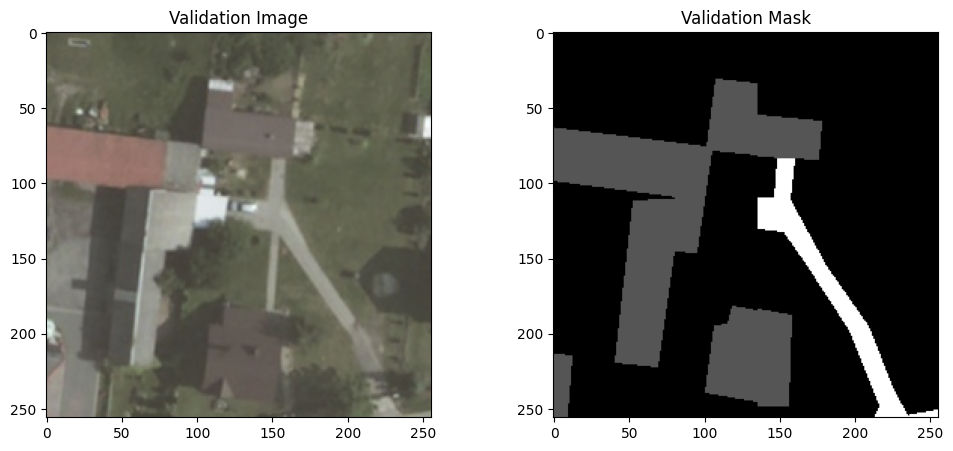

Batch shape: Images (16, 256, 256, 3), Masks (16, 256, 256, 4)


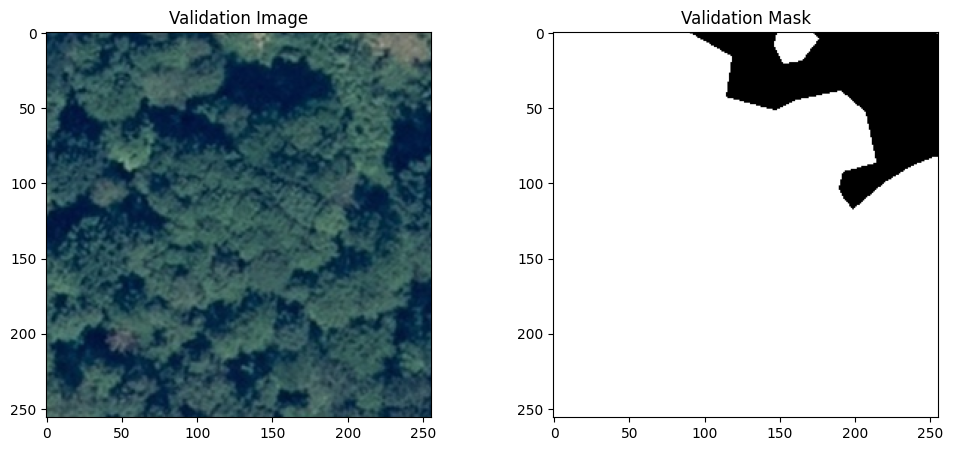

Test Samples:
Found 2194 images and 2194 masks in /kaggle/input/lulc-data/data_for_training_and_testing/test/images/
Batch shape: Images (16, 256, 256, 3), Masks (16, 256, 256, 4)


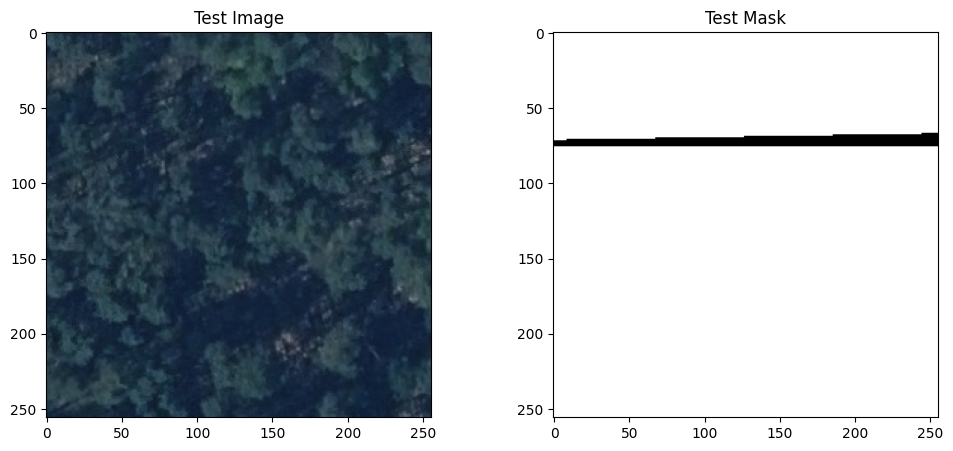

Batch shape: Images (16, 256, 256, 3), Masks (16, 256, 256, 4)


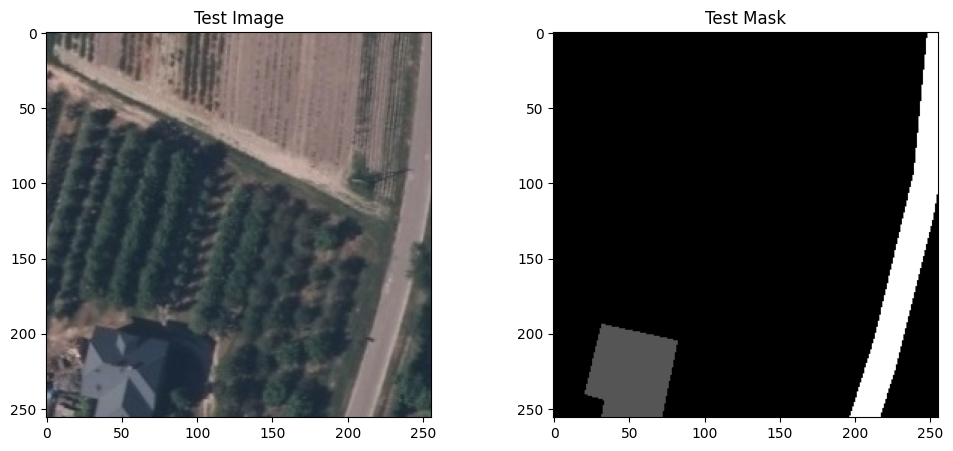

In [9]:
# Verify data loading

num_samples = 2
print("Validation Samples:")
try:
    for _ in range(num_samples):
        x, y = next(val_img_gen)
        print(f"Batch shape: Images {x.shape}, Masks {y.shape}")
        image = x[0]
        mask = np.argmax(y[0], axis=2)
        plt.figure(figsize=(12, 5))
        plt.subplot(121)
        plt.imshow(image)
        plt.title('Validation Image')
        plt.subplot(122)
        plt.imshow(mask, cmap='gray')
        plt.title('Validation Mask')
        plt.show()
except Exception as e:
    print(f"Error in validation generator: {e}")

print("Test Samples:")
try:
    for _ in range(num_samples):
        x, y = next(test_img_gen)
        print(f"Batch shape: Images {x.shape}, Masks {y.shape}")
        image = x[0]
        mask = np.argmax(y[0], axis=2)
        plt.figure(figsize=(12, 5))
        plt.subplot(121)
        plt.imshow(image)
        plt.title('Test Image')
        plt.subplot(122)
        plt.imshow(mask, cmap='gray')
        plt.title('Test Mask')
        plt.show()
except Exception as e:
    print(f"Error in test generator: {e}")

## Predictions and Evaluation

In [10]:
# Function to evaluate IoU over entire dataset
def evaluate_iou(model, generator, num_images, batch_size, n_classes):
    IOU_keras = MeanIoU(num_classes=n_classes)
    steps = (num_images + batch_size - 1) // batch_size  # Ceiling division
    for _ in range(steps):
        try:
            images, masks = next(generator)
            preds = model.predict(images, verbose=0)
            masks_argmaxed = np.argmax(masks, axis=3)
            preds_argmaxed = np.argmax(preds, axis=3)
            IOU_keras.update_state(preds_argmaxed, masks_argmaxed)
        except Exception as e:
            print(f"Error processing batch: {e}")
            continue
    return IOU_keras.result().numpy()

### 1. Validation Dataset Predictions and evaluation

In [11]:
# Evaluate on entire validation dataset
num_val_images = len(os.listdir(val_img_dir))
val_iou = evaluate_iou(model, val_img_gen, num_val_images, batch_size, n_classes)
print("Mean IoU (Validation, Entire Dataset) =", val_iou)

I0000 00:00:1746370740.294896     186 service.cc:148] XLA service 0x7cd5840af4e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746370740.295702     186 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746370740.752513     186 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746370748.421450     186 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Mean IoU (Validation, Entire Dataset) = 0.7911055


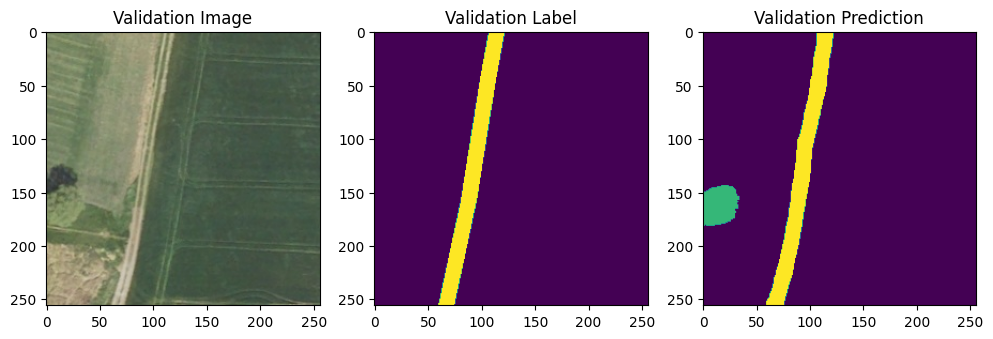

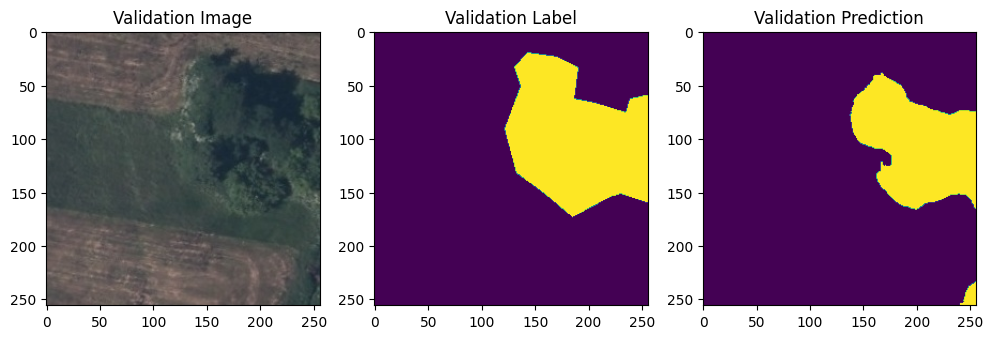

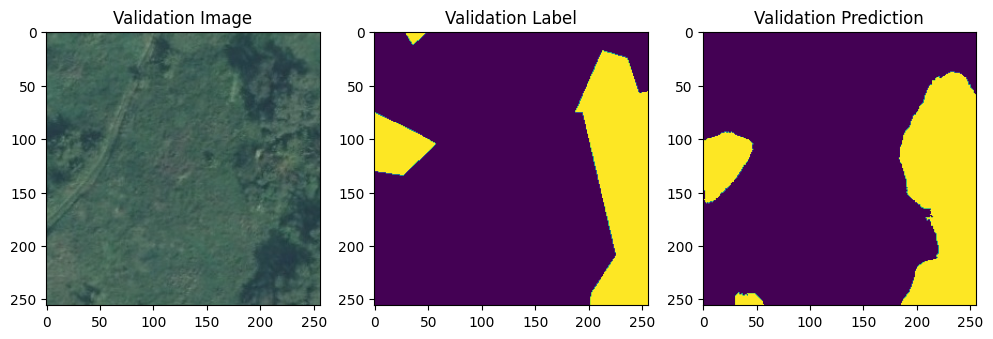

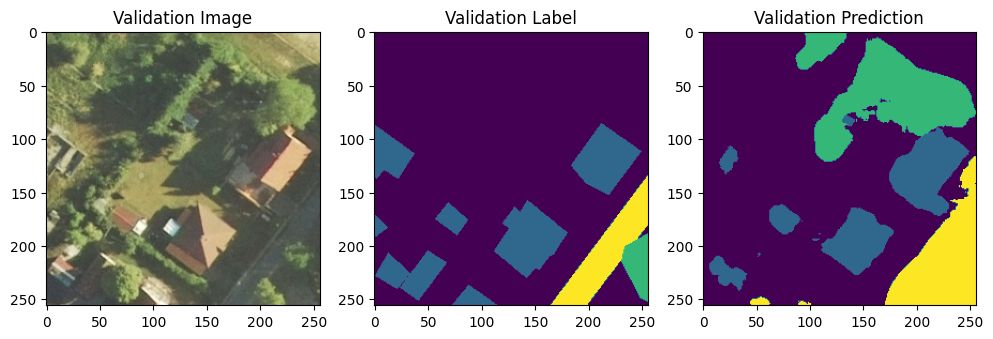

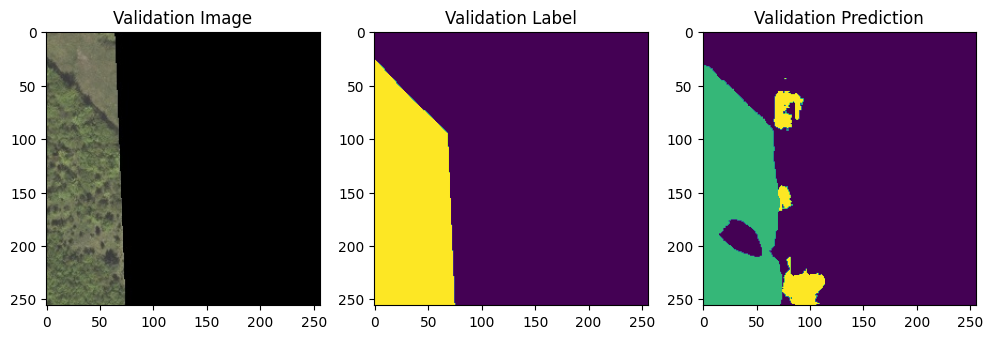

In [16]:
# Visualize 5 random validation samples
try:
    for i in range(5):
        test_image_batch, test_mask_batch = val_img_gen.__next__()
        test_pred_batch = model.predict(test_image_batch, verbose=0)
        test_mask_argmaxed = np.argmax(test_mask_batch, axis=3)
        test_pred_argmaxed = np.argmax(test_pred_batch, axis=3)
        img_num = np.random.randint(0, test_image_batch.shape[0])
        plt.figure(figsize=(12, 8))
        plt.subplot(231)
        plt.title(f'Validation Image')
        plt.imshow(test_image_batch[img_num])
        plt.subplot(232)
        plt.title(f'Validation Label')
        plt.imshow(test_mask_argmaxed[img_num])
        plt.subplot(233)
        plt.title(f'Validation Prediction')
        plt.imshow(test_pred_argmaxed[img_num])
        plt.show()
except Exception as e:
    print(f"Error in validation visualization: {e}")

### 2. TestDataset Predictions and evaluation

In [13]:
# Evaluate on entire test dataset
num_test_images = len(os.listdir(test_img_dir))
test_iou = evaluate_iou(model, test_img_gen, num_test_images, batch_size, n_classes)
print("Mean IoU (Test, Entire Dataset) =", test_iou)

Mean IoU (Test, Entire Dataset) = 0.7984109


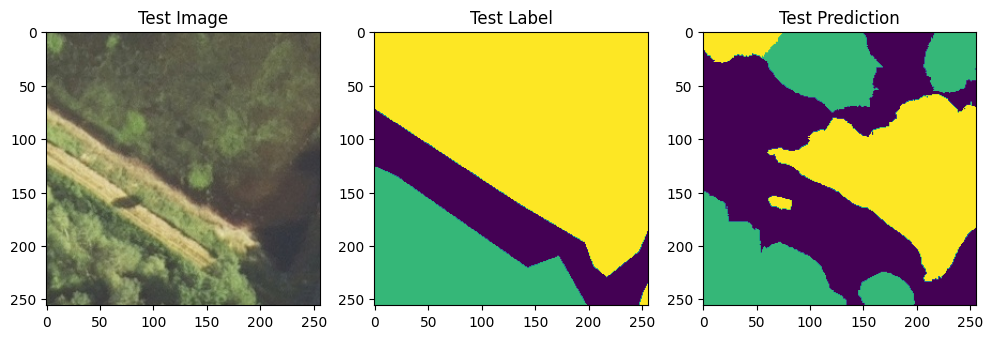

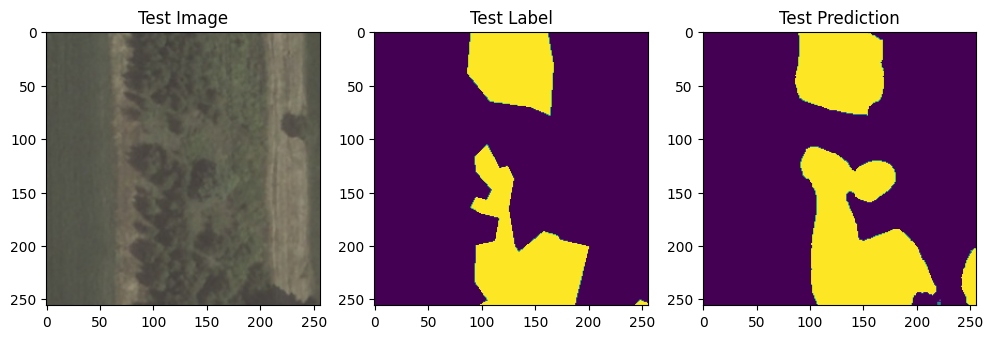

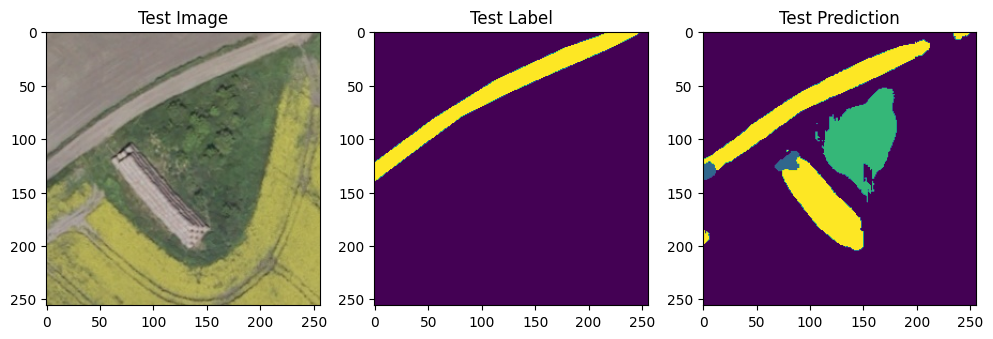

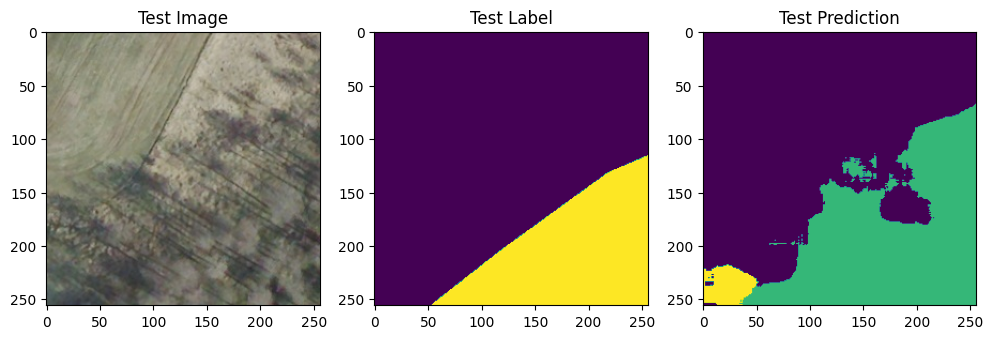

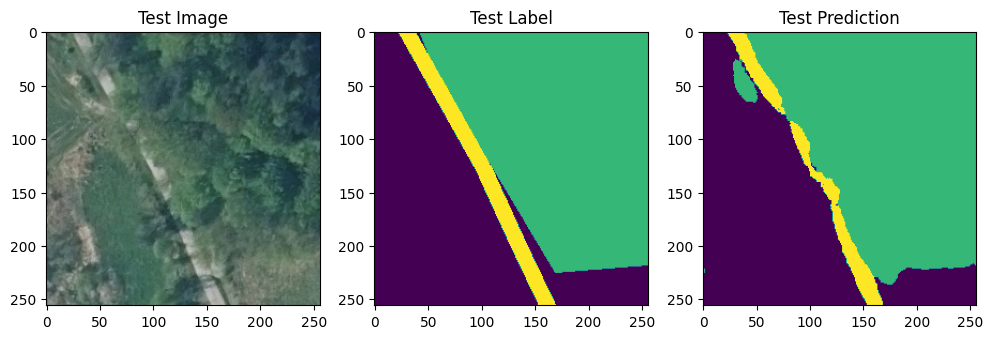

In [31]:
# Visualize 5 random test samples
try:
    for i in range(5):
        new_test_image_batch, new_test_mask_batch = test_img_gen.__next__()
        new_test_pred_batch = model.predict(new_test_image_batch, verbose=0)
        new_test_mask_argmaxed = np.argmax(new_test_mask_batch, axis=3)
        new_test_pred_argmaxed = np.argmax(new_test_pred_batch, axis=3)
        img_num = np.random.randint(0, new_test_image_batch.shape[0])
        plt.figure(figsize=(12, 8))
        plt.subplot(231)
        plt.title(f'Test Image')
        plt.imshow(new_test_image_batch[img_num])
        plt.subplot(232)
        plt.title(f'Test Label')
        plt.imshow(new_test_mask_argmaxed[img_num])
        plt.subplot(233)
        plt.title(f'Test Prediction')
        plt.imshow(new_test_pred_argmaxed[img_num])
        plt.show()
except Exception as e:
    print(f"Error in test visualization: {e}")

## Performance metrics


==================== PERFORMANCE METRICS COMPARISON ====================
Metric   |   Validation |      Test |       Diff
---------------------------------------------------------
Mean IoU |    0.7911 |    0.7984 |     0.0073
Loss     |    0.4250 |    0.4842 |     0.0592


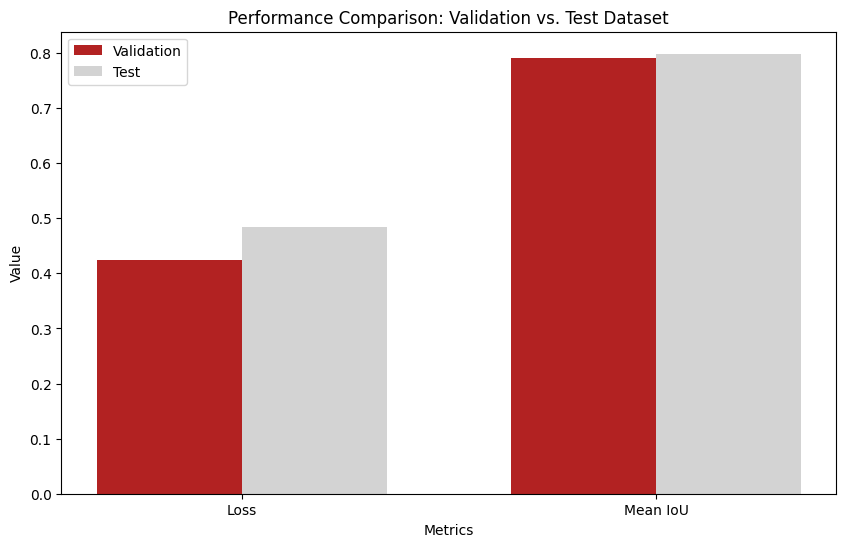

In [15]:
# Compare performance metrics
try:
    # Recompute loss on a single batch for consistency with previous code
    test_image_batch, test_mask_batch = val_img_gen.__next__()
    test_pred_batch = model.predict(test_image_batch, verbose=0)
    val_loss = np.mean(tf.keras.losses.categorical_crossentropy(test_mask_batch, test_pred_batch))

    new_test_image_batch, new_test_mask_batch = test_img_gen.__next__()
    new_test_pred_batch = model.predict(new_test_image_batch, verbose=0)
    test_loss = np.mean(tf.keras.losses.categorical_crossentropy(new_test_mask_batch, new_test_pred_batch))

    print("\n==================== PERFORMANCE METRICS COMPARISON ====================")
    print("Metric   |   Validation |      Test |       Diff")
    print("---------------------------------------------------------")
    print(f"Mean IoU |    {val_iou:.4f} |    {test_iou:.4f} |     {(test_iou - val_iou):.4f}")
    print(f"Loss     |    {val_loss:.4f} |    {test_loss:.4f} |     {(test_loss - val_loss):.4f}")

    metrics = ['Loss', 'Mean IoU']
    original_values = [val_loss, val_iou]
    new_values = [test_loss, test_iou]

    plt.figure(figsize=(10, 6))
    x = np.arange(len(metrics))
    width = 0.35
    plt.bar(x - width/2, original_values, width, label='Validation', color='#B22222')
    plt.bar(x + width/2, new_values, width, label='Test', color='#D3D3D3')
    plt.xlabel('Metrics')
    plt.ylabel('Value')
    plt.title('Performance Comparison: Validation vs. Test Dataset')
    plt.xticks(x, metrics)
    plt.legend()
    plt.show()
except Exception as e:
    print(f"Error in performance comparison: {e}")